In [357]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima import model_selection

from get_forex_data import get_daily_data, get_small_frequencies

from plot import plot_basic_close, pred_vs_real_plot

In [358]:
import yfinance as yf
yf.pdr_override()

In [359]:
PAIR = 'CHFJPY'
START = '2022-01-01'
END = '2023-09-09'

## Fetch daily data

In [360]:
df_daily = get_daily_data(PAIR, START, END)

df_daily.tail()

# dataframe to join the prediction table at the end
original_data = df_daily.copy().reset_index(names='date')

original_data['tag'] = 'historical'

original_data = original_data[['date','Adj Close','tag']]

# slice the last two weeks
original_data = original_data.tail(14)

original_data.head()

[*********************100%%**********************]  1 of 1 completed


,date,Adj Close,tag
426,2023-08-22,166.45,historical
427,2023-08-23,165.60,historical
428,2023-08-24,164.87,historical
429,2023-08-25,164.98,historical
430,2023-08-28,165.60,historical


## Plot the close price

In [361]:
# plot_basic_close((15,7), df_daily, PAIR) 

## Get Hourly Data

In [362]:
df_hourly = get_small_frequencies(PAIR, period='30d', interval='1h')
df_hourly.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-15 17:00:00+01:00,164.994995,165.076996,164.938995,164.951004,164.951004,0
2023-09-15 18:00:00+01:00,164.951996,164.957001,164.807999,164.908005,164.908005,0
2023-09-15 19:00:00+01:00,164.912994,164.912994,164.723007,164.792007,164.792007,0
2023-09-15 20:00:00+01:00,164.789001,164.800003,164.735992,164.764999,164.764999,0
2023-09-15 21:00:00+01:00,164.763000,164.787994,164.669006,164.727997,164.727997,0


In [363]:
#plot_basic_close((25,10), df_hourly, PAIR)   

## Daily Predicion

In [364]:
y = df_daily['Adj Close']

In [365]:
y

Date
2022-01-03    126.23
2022-01-04    125.57
2022-01-05    126.79
2022-01-06    126.57
2022-01-07    125.73
               ...  
2023-09-04    164.93
2023-09-05    165.61
2023-09-06    165.78
2023-09-07    165.69
2023-09-08    165.02
Name: Adj Close, Length: 440, dtype: float64

In [366]:

est = pm.ARIMA(order=(1, 1, 2),
               seasonal_order=(0, 1, 1, 12),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=50, step=5, h=5)
validation = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [367]:
x_axis = np.arange(y.shape[0])
n_test = validation.shape[0]

In [368]:
validation.shape[0]

390

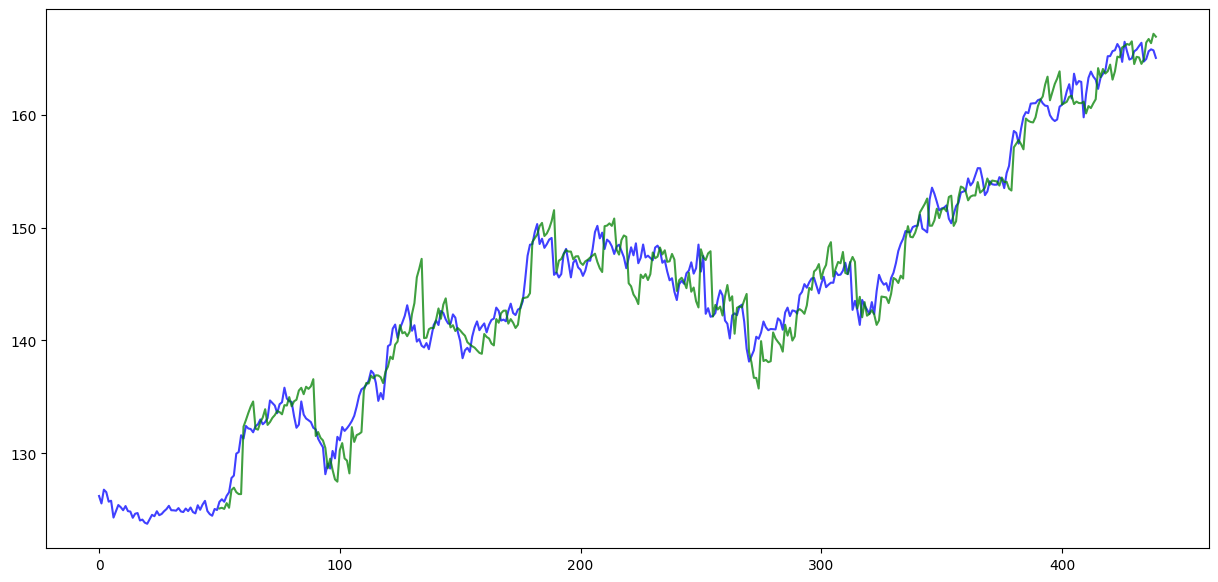

In [369]:
from plot import pred_vs_real_plot
pred_vs_real_plot(df_daily, PAIR , x_axis, y, validation, n_test)    

## Predict the next two weeks

In [370]:
predictions = est.fit(y).predict()

In [371]:
predictions = predictions.to_frame(name='Adj Close').reset_index(names='date')

predictions['tag'] = 'prediction'

# round prediction values
predictions['Adj Close'] = predictions['Adj Close'].apply(lambda x: round(x,2))

all_df = pd.concat([predictions, original_data]).sort_values(by='date')




In [372]:
## create the reality dataset
df_daily_plus_three = get_daily_data(PAIR, START, '2023-09-16')

df_daily_plus_three = df_daily_plus_three.reset_index(names='Date')

df_daily_plus_three = df_daily_plus_three.tail(15)

[*********************100%%**********************]  1 of 1 completed


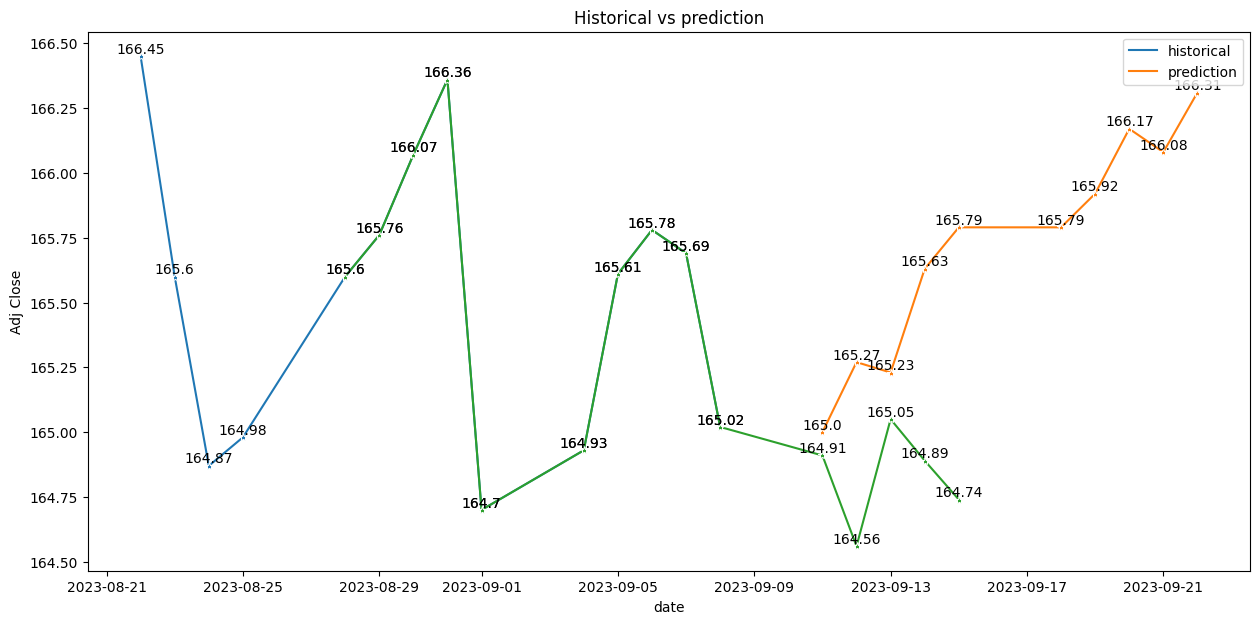

In [373]:
import seaborn as sns
plt.figure(figsize=(15,7))


ax = sns.lineplot(x = 'date', y = 'Adj Close', marker='*',  data = all_df,  hue='tag') 
# sns.lineplot(x = 'Date', y = 'Adj Close', marker='*',  data = df_daily_plus_one.reset_index())

ax.set(title='Historical vs prediction')

ax2 = sns.lineplot(x = 'Date', y = 'Adj Close', marker='*',  data = df_daily_plus_three)

# data labels
for i, j in zip(all_df.date, all_df['Adj Close']):
    plt.text(i, j, str(j), ha='center', va='bottom')
    
for i, j in zip(df_daily_plus_three.Date, df_daily_plus_three['Adj Close']):
    plt.text(i, j, str(j), ha='center', va='bottom')    

In [374]:
# this is a test